<a href="https://colab.research.google.com/github/paulsubarna/DGM_tutorials-/blob/main/DGM_tutorial_6_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Diffusion models roughly consist of two parts:

- A predefined **forward** diffusion process $q(\boldsymbol{x}_t|\boldsymbol{x}_{t-1})$ of our choosing, that gradually adds Gaussian noise to an image until it becomes pure noise.
- A **reverse** denoising diffusion process $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$, approximated by a neural network, which gradually denoises an image starting from pure noise.

<img src="setup.jpg" width="700" align="center"/>

### Forward process

<img src="forward.jpg" width="1000" align="center"/>

<span style="color:purple"> **Nice property:** </span> Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$

$$
\begin{align}
\boldsymbol{x}_t & = \sqrt{\alpha_t} \boldsymbol{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{z}_{t-1} \;\;\; \text{where} \;\boldsymbol{z}_{t-1}, \boldsymbol{z}_{t-2}, \dots, \mathcal{N}(\mathbf{0}, \mathbf{I}).\\
    & =  \sqrt{\alpha_t} \lbrack \sqrt{\alpha_{t-1}} \boldsymbol{x}_{t-2} + \sqrt{1- \alpha_{t-1}}\boldsymbol{z}_{t-2} \rbrack + \sqrt{1 - \alpha_t}\boldsymbol{z}_{t-1}\\
    & = \sqrt{\alpha_t \alpha_{t-1}} \boldsymbol{x}_{t-2} + \sqrt{\alpha_t - \alpha_t \alpha_{t-1}}\boldsymbol{z}_{t-2} + \sqrt{1 - \alpha_t}\boldsymbol{z}_{t-1}\\
    & = \sqrt{\alpha_t \alpha_{t-1}} \boldsymbol{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}}\boldsymbol{\bar{z}}_{t-2} \;\;\; \text{where} \; \boldsymbol{\bar{z}}_{t-2} \; \text{merges two Gaussians}^1 \\
    & = \dots \\
    & = \sqrt{\bar{\alpha}_t} \boldsymbol{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\bar{z}_0} \;\;\; \text{where} \; \boldsymbol{\bar{z}_0} = \boldsymbol{z} \\
q(\boldsymbol{x}_t|\boldsymbol{x}_0)    & = \mathcal{N}(\sqrt{\bar{\alpha}_t} \boldsymbol{x}_0, 1 - \bar{\alpha}_t)
\end{align}
$$

$^1$ the sum of two Gaussian variables $\boldsymbol{z}_1 \sim \mathcal{N}(\mathbf{0}, \sigma_1^2 \mathbf{I})$ and $\boldsymbol{z}_2 \sim \mathcal{N}(\mathbf{0}, \sigma_2^2 \mathbf{I})$ is a new variable $\bar{\boldsymbol{z}} \sim \mathcal{N}(\mathbf{0}, (\sigma_1^2 + \sigma_2^2) \mathbf{I})$. In our case, $\boldsymbol{z}_{t-1} \sim \mathcal{N}(\mathbf{0}, (1-\alpha_t) \mathbf{I})$ and $\boldsymbol{z}_{t-2} \sim \mathcal{N}(\mathbf{0}, (\alpha_t - \alpha_t \alpha_{t-1}) \mathbf{I})$, so $\boldsymbol{\bar{z}}_{t-2} \sim \mathcal{N}(\mathbf{0}, (1 - \alpha_t \alpha_{t-1}) \mathbf{I})$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torchvision

First, we define the scheduler to compute $\beta_t$. The simplest is the linear scheduler, but more advanced schedulers can give better results.

In [ ]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

In [ ]:
timesteps = 200

# compute betas
betas = linear_beta_schedule(timesteps=timesteps)

# compute alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# calculations for the forward diffusion q(x_t | x_{t-1})
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

Let's illustrate how noise is added to a sample image at each time step of the diffusion process.

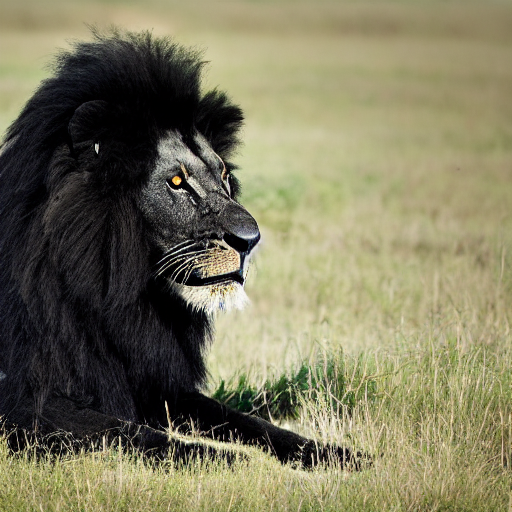

In [ ]:
from PIL import Image
image = Image.open("/app/src/lion_short.png")
image

Next, we resize the image, rescale it in $[-1, 1]$, and convert it to a PyTorch tensor.

In [ ]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1), # [0,1] --> [-1,1]
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

We also define the reverse transform, which maps a PyTorch tensor with in $[−1,1]$ back into a PIL image.

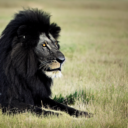

In [ ]:
reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

reverse_transform(x_start.squeeze())

We can now define the forward diffusion process.

In [ ]:
# utility function to extract the appropriate t index for a batch of indices.
# e.g., t=[10,11], x_shape=[b,c,h,w] --> a.shape = [2,1,1,1]
# e.g., t=[7,12,15,20], x_shape=[b,h,w] --> a.shape = [4,1,1]
def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# forward diffusion (using the nice property)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start) # z (it does not depend on t!)

    # adjust the shape
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test on a specific time step, $t=20$:

In [ ]:
def get_noisy_image(x_start, t):

  x_noisy = q_sample(x_start, t=t) # add noise
  noisy_image = reverse_transform(x_noisy.squeeze()) # turn back into PIL image

  return noisy_image

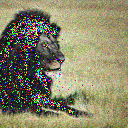

In [ ]:
t = torch.tensor([19])
get_noisy_image(x_start[0], t)

In [ ]:
def plot_seq(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
plot_seq([get_noisy_image(x_start, torch.tensor([t])) for t in [1, 50, 100, 150, 199]])

### Backward process

<img src="backward.jpg" width="700" align="center"/>

- If $\beta_t$ is small enough, $q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)$ will be a Gaussian $\mathcal{N}\big(\tilde{\mu}(\boldsymbol{x}_t), \tilde{\sigma}(\boldsymbol{x}_t)\big)$
- However, we cannot compute $\tilde{\mu}(\boldsymbol{x}_t)$ and $\tilde{\sigma}(\boldsymbol{x}_t)$ analytically, because requires knowing the true data distribution $p(\boldsymbol{x})$
$$ q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t)q(\boldsymbol{x}_{t-2}|\boldsymbol{x}_{t-1})\dots \rightarrow  p(\boldsymbol{x}_0)$$
- We can use a NN to learn $\tilde{\mu}(\boldsymbol{x}_t)$ and $\tilde{\sigma}(\boldsymbol{x}_t)$

### Simplification

Represent $\tilde{\sigma}(\boldsymbol{x}_t)$ with a time dependent constant $\tilde{\beta}_t$

### Manipulation

Condition on $\boldsymbol{x}_0$ and obtain
$q(\boldsymbol{x}_{t-1}|\boldsymbol{x}_t, \boldsymbol{x}_0) = \mathcal{N} \big( \tilde{\mu}(\boldsymbol{x}_t, \boldsymbol{x}_0), \tilde{\beta}_t \big) = \mathcal{N} \big( \tilde{\mu}_t, \tilde{\beta}_t \big)$

where

$$\tilde{\beta}_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t$$

and

$$\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \Big(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\tilde z}_t \Big)$$

<img src="posterior_derivation.jpg" width="900" align="center"/>

### NN Model

- Take a look at $\tilde{\beta}_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t$ and $\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \Big(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\tilde z}_t \Big)$
- The only thing we do not know is $\boldsymbol{\tilde z}_t$.
- We approximate $\boldsymbol{\tilde z}_t$ with a NN.

<img src="dae.jpg" width="700" align="center"/>

As NN, we use a Unet.

![unet.png](unet.png)

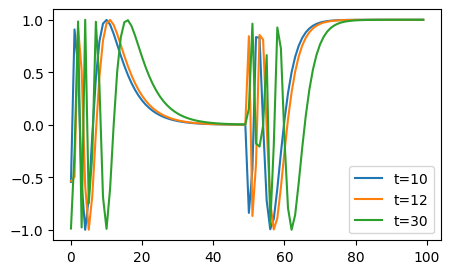

In [ ]:
import math
import matplotlib.pyplot as plt
import torch
from torch import nn

# Define SinusoidalPositionEmbeddings class here to resolve ModuleNotFoundError
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

time_emb = SinusoidalPositionEmbeddings(100)
t1 = time_emb(torch.tensor([10]))
t2 = time_emb(torch.tensor([12]))
t3 = time_emb(torch.tensor([30]))

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(t1.numpy()[0], label='t=10')
ax.plot(t2.numpy()[0], label='t=12')
ax.plot(t3.numpy()[0], label='t=30')
plt.legend();

In [ ]:
# Let's check the input and output of the U-net
# from scripts.unet import Unet # This line caused the ModuleNotFoundError

import torch
from torch import nn
import torch.nn.functional as F
import math

# --- Start of Unet and helper definitions (normally in scripts/unet.py) ---

# Redefine SinusoidalPositionEmbeddings for self-contained cell
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim_in, dim_out, groups=8):
        super().__init__()
        self.proj = nn.Conv2d(dim_in, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim_in, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if time_emb_dim is not None else None

        self.block1 = Block(dim_in, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim_in, dim_out, 1) if dim_in != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = time_emb.reshape(time_emb.shape[0], time_emb.shape[1], 1, 1)
            scale_shift = time_emb.chunk(2, dim=1)

        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups = 8,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels
        # Calculate initial_dim, ensuring it's divisible by resnet_block_groups
        _init_dim_val = init_dim if init_dim is not None else dim // 3 * 2
        if _init_dim_val % resnet_block_groups != 0:
            _init_dim_val = (_init_dim_val // resnet_block_groups + 1) * resnet_block_groups
        init_dim = _init_dim_val

        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        # Construct the raw list of dimensions based on dim_mults
        dims_raw = [init_dim] + [dim * mult for mult in dim_mults]

        # Ensure all dimensions in the dims list are divisible by resnet_block_groups
        dims = []
        for d_val in dims_raw:
            if d_val % resnet_block_groups != 0:
                dims.append((d_val // resnet_block_groups + 1) * resnet_block_groups)
            else:
                dims.append(d_val)

        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = ResnetBlock

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        ) if with_time_emb else None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_out, time_emb_dim=time_dim, groups = resnet_block_groups),
                block_klass(dim_out, dim_out, time_emb_dim=time_dim, groups = resnet_block_groups),
                nn.Conv2d(dim_out, dim_out, 4, 2, 1) if not is_last else nn.Identity()
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, groups = resnet_block_groups)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim, groups = resnet_block_groups)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(nn.ModuleList([
                block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim, groups = resnet_block_groups),
                block_klass(dim_in, dim_in, time_emb_dim=time_dim, groups = resnet_block_groups),
                nn.ConvTranspose2d(dim_in, dim_in, 4, 2, 1) if not is_last else nn.Identity()
            ]))

        out_dim = out_dim if out_dim is not None else channels
        self.final_conv = nn.Sequential(
            block_klass(init_dim, init_dim, groups=resnet_block_groups), # Explicitly pass groups here
            nn.Conv2d(init_dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if self.time_mlp is not None else None

        h = []

        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        return self.final_conv(x)

# --- End of Unet and helper definitions ---

### Loss

<img src="loss.jpg" width="600" align="center"/>



- Loss: $\| \boldsymbol{z}_{t-1} - \boldsymbol{\tilde z}_{t} \|_1 = \| \boldsymbol{z}_{t-1} - \text{NN}(\boldsymbol{x}_t, t) \|_1$
- $\boldsymbol{z}_{t-1}$ is the noise used to compute $\boldsymbol{x}_t$ in the forward process
- Remember that to compute $\boldsymbol{x}_t$ we dropped the time index on $\boldsymbol{z}$ (nice property):
$$ \boldsymbol{x}_t = \sqrt{\bar \alpha_t} \boldsymbol{x}_0 + \sqrt{1 - \bar \alpha_t} \boldsymbol{z} $$
- Simply, we can sample $\boldsymbol{z}$, compute $\boldsymbol{x}_t$, and recover $\boldsymbol{z}$ with the $\text{NN}$

### Training

<img src="train.jpg" width="600" align="center"/>

**repeat**
- Sample an image from the training data
    - $\boldsymbol{x}_0 \sim p(\boldsymbol{x}_0)$
- Sample $\boldsymbol{z}$ and $t$ randomly
    - $t \sim \mathcal{U}([1, T])$
    - $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$
- Take gradient descent step on $\nabla_\theta \| \boldsymbol{z} - \text{NN}( \sqrt{\bar \alpha_t} \boldsymbol{x}_0 + \sqrt{1 - \bar \alpha_t} \boldsymbol{z}) \|_1$

**until** converged

In [ ]:
def p_losses(denoise_model, x_start, t, loss_type="huber"):

    # random sample z
    noise = torch.randn_like(x_start)

    # compute x_t
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # recover z from x_t with the NN
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

### Sampling

We said that $\boldsymbol{x}_{t-1} \sim \mathcal{N}(\tilde{\mu}_t, \tilde{\beta}_t)$ where

$$\tilde{\beta}_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t$$

and

$$\tilde{\mu}_t = \frac{1}{\sqrt{\alpha_t}} \Big(\boldsymbol{x}_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\tilde z}_t \Big)$$

<img src="sampling.jpg" width="600" align="center"/>

#### *Sampling algorithm*
$\boldsymbol{x}_T \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$

**for** $t=T-1, \dots, 0$ **do**
- $\boldsymbol{z} \sim \mathcal{N}(\boldsymbol{0}, \boldsymbol{I})$ if $t > 1$ else $\boldsymbol{z}=0$
- $\boldsymbol{x}_{t-1} = \frac{1}{\sqrt{\alpha_t}} \big( \boldsymbol{x}_{t} - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \text{NN}(\boldsymbol{x}_t, t) \big) + \tilde{\beta}_t \boldsymbol{z}$

**return** $\boldsymbol{x}_{0} = \mu_0$

In [ ]:
# calculations for posterior q(x_{t-1} | x_t, x_0) = q(x_{t-1} | t, x_0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # β_t

@torch.no_grad()
def p_sample(model, x, t, t_index):

    # adjust shapes
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Use the NN to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    # Draw the next sample
    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)  # beta_t
        noise = torch.randn_like(x)                                     # z
        return model_mean + torch.sqrt(posterior_variance_t) * noise    # x_{t-1}

In [ ]:
# Sampling loop
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((shape[0],), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

### Train the model on Fashion MNIST

<img src="fashion.png" width="600" align="center"/>

In [ ]:
from datasets import load_dataset

dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Generating test split: 100%|████████████████████████████████████████| 10000/10000 [00:00<00:00, 369542.20 examples/s]


Next, we define some basic image preprocessing on-the-fly: random horizontal flips, converstion to tensor, and rescaling in the $[-1,1]$ range.

We use ``with_transform`` to apply the transformations to the elements in the dataset.

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [ ]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    resnet_block_groups=1 # Fix: Ensure num_channels is divisible by num_groups
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
from torchvision.utils import save_image

epochs = 50

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      # x0
      batch_size = batch["pixel_values"].shape[0]
      batch = batch["pixel_values"].to(device)

      # sample t from U(0,T)
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t)

      if step % 100 == 0:
        print(f"Epoch: {epoch}, step: {step} -- Loss: {loss.item():.3f}")

      loss.backward()
      optimizer.step()

### Inference

Once trained, we can sample from the model using ``sample`` the function defined above:

sampling loop time step: 100%|████████████████████████████████████████████████████| 200/200 [00:01<00:00, 138.44it/s]


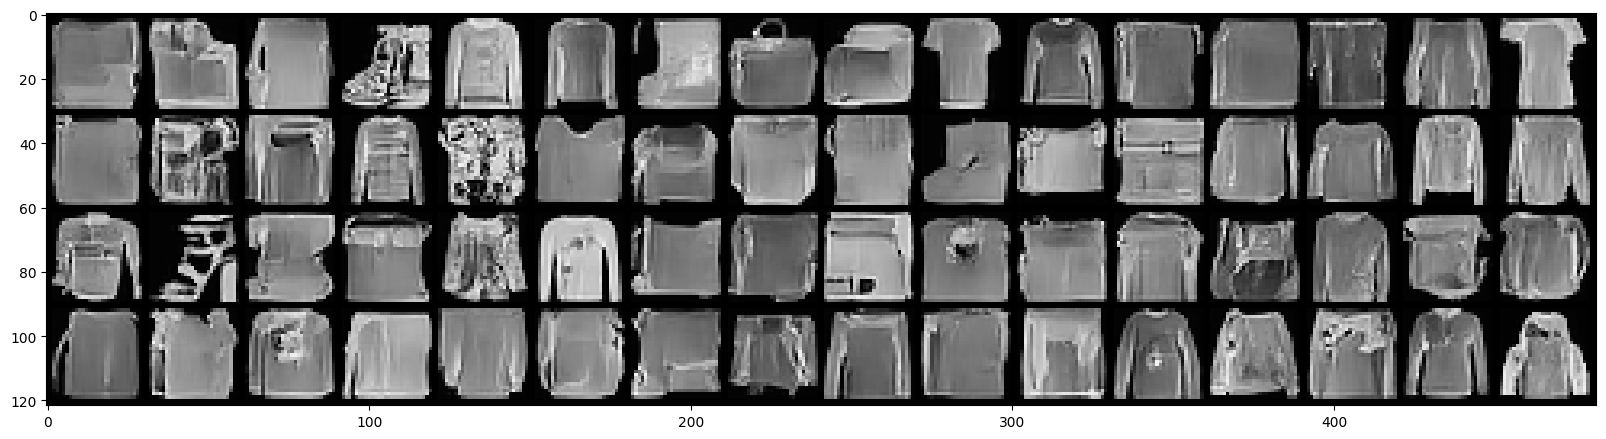

In [ ]:
# Generate 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

# Get the last sample and normalize it in [0,1]
last_sample = (samples[-1] - samples[-1].min())/(samples[-1].max()-samples[-1].min())

grid_img = torchvision.utils.make_grid(last_sample, nrow=16)
%matplotlib inline
plt.figure(figsize = (20,10))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray');

Visualize the actual denoising process with an animation

In [ ]:
import matplotlib.animation as animation
%matplotlib notebook

random_index = 6

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].cpu().numpy().reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('/app/src/diffusion.gif')
plt.show()

<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.


## Next steps

- Sample generation can be conditioned on inputs such as text (text2img) and images (img2img) [[4](https://arxiv.org/abs/2204.06125)].
- Besides the mean, learning the standard deviation <span style="color:orange"> $$\tilde{\sigma}(\boldsymbol{x}_t)$$ </span> of the conditional distribution helps in improving performance [[5](https://arxiv.org/abs/2102.09672)].
- More advanced noise scheduler than the linear one can give better performance and decrease inference time [[6](https://arxiv.org/abs/2010.02502)]
- Diffusion in the pixel space is slow. Latent diffusion, in the embedding space, can speed-up inference time greatly [[7](https://openaccess.thecvf.com/content/CVPR2022/html/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.html)]

## Conditioned generation with diffusion guidance

### Score-Based Generative Models

- Different from DDPM, yet equivalent in nature, are the **score-based** methods [[8](https://openreview.net/forum?id=PxTIG12RRHS)]
-  *Score-based generative models* and DDPM are different perspectives of the same model family
- In this perspective, the desnoising process corresponds to taking steps in the direction of the **score function**
$$\nabla_x \log{p(x)}$$
i.e., the direction where the log-likelihood increases the most
- In the process, noise is added to avoid getting stuck between the modes of the distribution
- This is called Stochastic Gradient Langevin Dynamics (SGLD)

![score_fun](img/score_fun.jpeg)

### Conditional models

- In conditional models, we want to model $p(x|y)$
- In the score-based perspective, it means following during diffusion the score function: $\nabla_x \log{p(x|y)}$
- By applying Bayes' rule
$$ p(x|y) = \frac{p(y|x)p(x)}{p(y)}$$
that gives us
$$ \nabla_x \log{p(x|y)} = \nabla_x \log{p(y|x)} + \nabla_x \log{p(x)} - \nabla_x \log{p(y)} = \nabla_x \log{p(y|x)} + \nabla_x \log{p(x)}$$
- Notice that $p(y|x)$ is exactly what an image classifier tries to fit
- If the image classifier is a neural net, it is easy to compute $\nabla_x \log{p(y|x)}$

- We can give different contributions to the score function and the classfier
$$\nabla_x \log{p_\gamma(x|y)} = \nabla_x \log{p(x)}  + \gamma \nabla_x \log{p(y|x)},$$ where $\gamma$ is the **guidance scale** [[9](https://proceedings.neurips.cc/paper/2021/file/49ad23d1ec9fa4bd8d77d02681df5cfa-Paper.pdf)]
- The larger $\gamma$,  the larger is the influence of the conditioning signal
- Reverting the gradient and the logarithm operations, we see that $p_\gamma(x|y) \propto p(x)p(y|x)^\gamma$
- When $\gamma >1$, this sharpens the distribution and shift probability mass towards the values $x$ that are most likely associated with label $y$

<img src="img/guidance.jpg" width="800" align="center"/>

- ⚠️ Important: the diffusion model is trained as before and *only* at inference time is conditioned by a (pre-trained) classifier
- Similar to train a powerful unconditional NLP model and adapt it to downstream tasks via few-shot learning

**Limitations**

❌ Pre-trained classifiers cannot deal with noise
- The classifier used for guidance needs to cope with high noise to provide a useful signal through the sampling process
- This usually requires training the classifier specifically for the purpose of guidance
- At that point, it might be easier to train a traditional conditional generative model end-to-end...

❌ Classifiers take shortcuts
- Most of the information in the input $x$ is not accounted in predicting $y$
- As result, taking the gradient of the classifier w.r.t. its input can yield arbitrary directions in input space

### Classifier-free guidance (cfg)

- We said that $\nabla_x \log{p(x|y)} = \nabla_x \log{p(y|x)} + \nabla_x \log{p(x)}$
- Now, let's express the conditioning term as a function of the conditional and unconditional score functions, both of which our diffusion model provides
$$ \nabla_x \log{p(y|x)} = \nabla_x \log{p(x|y)} - \nabla_x \log{p(x)}$$

- Then, we substitute this into the formula for classifier guidance:
$$ \nabla_x \log{p_\gamma(x|y)} = \nabla_x \log{p(x)} + \gamma \big[ \nabla_x \log{p(x|y)} - \nabla_x \log{p(x)} \big]$$
- We expressed the conditional score function as a combination of the conditional and the unconditional score function itself
- We no longer need a classifier!

- cfg is implemented by removing the conditioning signal 10-20\% of times while training (**conditioning dropout**)[[11](https://arxiv.org/abs/2112.10741)]
- In practice, one replaces $y$ with a special input value representing the absence of conditioning information (e.g., ``""``)
- The resulting model is now able to function both as a conditional model $p(x|y)$ and as an unconditional model $p(x)$, depending on whether the conditioning signal is provided

Example: "*A stained glass window of a panda eating bamboo.*" with classifier guidance (left) and with cfg (right)

![pandas](img/pandas.png)

Why cfg is better than classifier guidance?
- cfg replaces the guidance from a standard classifier $\nabla_x \log{p(y|x)}$ with a "classifier" built from a generative model $\nabla_x \log{p(x|y)} - \nabla_x \log{p(x)}$.
- Standard classifiers can take shortcuts and ignore most of the input $x$ while still obtaining competitive classification results
- Instead, generative models are forced to consider the whole data distribution, making the gradient much more robust
- In addtion, we only have to train a single (generative) model, and conditioning dropout is trivial to implement

Limitation:
- cfg dramatically improves adherence to the conditioning signal and the overall sample quality at the cost of diversity
- This is a tipycal trade-off in generative models

### References


[[1](https://proceedings.neurips.cc/paper/2020/file/4c5bcfec8584af0d967f1ab10179ca4b-Paper.pdf)] Ho, J., Jain, A., Abbeel, P., (2020). Denoising diffusion probabilistic models. Advances in Neural Information Processing Systems.

[[2](https://huggingface.co/blog/annotated-diffusion)] Rogge, N., Rasul, K., (2022). The Annotated Diffusion Model.

[[3](https://benanne.github.io/2022/05/26/guidance.html)] Dieleman, S., (2022). Guidance: a cheat code for diffusion models.

[[4](https://arxiv.org/abs/2204.06125)] Ramesh, A., Dhariwal, P., Nichol, A., Chu, C., & Chen, M. (2022). Hierarchical text-conditional image generation with clip latents.

[[5](https://arxiv.org/abs/2102.09672)] Nichol, A. Q., & Dhariwal, P. (2021). Improved denoising diffusion probabilistic models. In International Conference on Machine Learning.

[[6](https://arxiv.org/abs/2010.02502)] Song, J., Meng, C., & Ermon, S. (2020). Denoising diffusion implicit models.

[[7](https://openaccess.thecvf.com/content/CVPR2022/html/Rombach_High-Resolution_Image_Synthesis_With_Latent_Diffusion_Models_CVPR_2022_paper.html)] Rombach, R., Blattmann, A., Lorenz, D., Esser, P., & Ommer, B. (2022). High-resolution image synthesis with latent diffusion models. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition.

[[8](https://openreview.net/forum?id=PxTIG12RRHS)] Song, Y., Sohl-Dickstein, J., Kingma, D. P., Kumar, A., Ermon, S., & Poole, B. (2021). Score-Based Generative Modeling through Stochastic Differential Equations. International Conference on Learning Representations.

[[9](https://proceedings.neurips.cc/paper/2021/file/49ad23d1ec9fa4bd8d77d02681df5cfa-Paper.pdf)] Dhariwal, P., & Nichol, A. (2021). Diffusion models beat gans on image synthesis. Advances in Neural Information Processing Systems.

[[10](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)] Weng, L., (2021). What are diffusion models?

[[11](https://arxiv.org/abs/2112.10741)] Nichol, A., Dhariwal, P., Ramesh, A., Shyam, P., Mishkin, P., McGrew, B., ... & Chen, M. (2021). Glide: Towards photorealistic image generation and editing with text-guided diffusion models.
